<a href="https://colab.research.google.com/github/mjavadpur/LSTM/blob/main/StockMarketSaipa_S4_MJavadpur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
from pandas.io.api import read_csv
import math
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin

yfin.pdr_override()

import numpy as np
import os
import io
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense , LSTM

import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow


# **Read Data**

In [2]:
# from google.colab import files
# uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive')





Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Workshop/StockMarkettingLSTM

/content/drive/MyDrive/Workshop/StockMarkettingLSTM


In [4]:
df = pd.read_csv('S_Saipa.csv',index_col='<DTYYYYMMDD>', parse_dates=True)
df = df.sort_index()
# df = df.iloc[df.index.year>2004]
df.shape

(4610, 11)

In [5]:



data = df.filter(['<CLOSE>'])

dataset = data.values

trainingDataLen = math.ceil(len(dataset)*.8)

scalar = MinMaxScaler(feature_range=(0,1))

scaled_data = scalar.fit_transform(dataset)


print(scaled_data.shape)

(4610, 1)


In [6]:


train_data = scaled_data[0:trainingDataLen,:]

x_train = []
y_train = []


for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])


type(x_train)

  

list

In [7]:
x_train , y_train = np.array(x_train) ,np.array(y_train) 

type(x_train)

numpy.ndarray

In [8]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

x_train.shape

(3628, 60, 1)

In [9]:

model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

model.add(LSTM(50,return_sequences=False))

model.add(Dense(25))

model.add(Dense(12))

model.add(Dense(1))


In [10]:
model.compile(optimizer='adam',loss='mean_squared_error')


In [11]:
model.fit(x_train,y_train,batch_size=1,epochs=1)



3628/3628 [==============================] - 111s 29ms/step - loss: 0.0016


In [12]:
test_data=scaled_data[trainingDataLen-60:,:]
print(len(test_data))
x_test=[] 
y_test=dataset[trainingDataLen:,:]
print(len(test_data))
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])
  

982
982


In [13]:
x_test=np.array(x_test)

In [14]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [15]:
predictions=model.predict(x_test)
predictions=scalar.inverse_transform(predictions)


29/29 [==============================] - 1s 16ms/step


In [16]:
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

317.65021063086783

<ipython-input-17-c5db0c24534c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


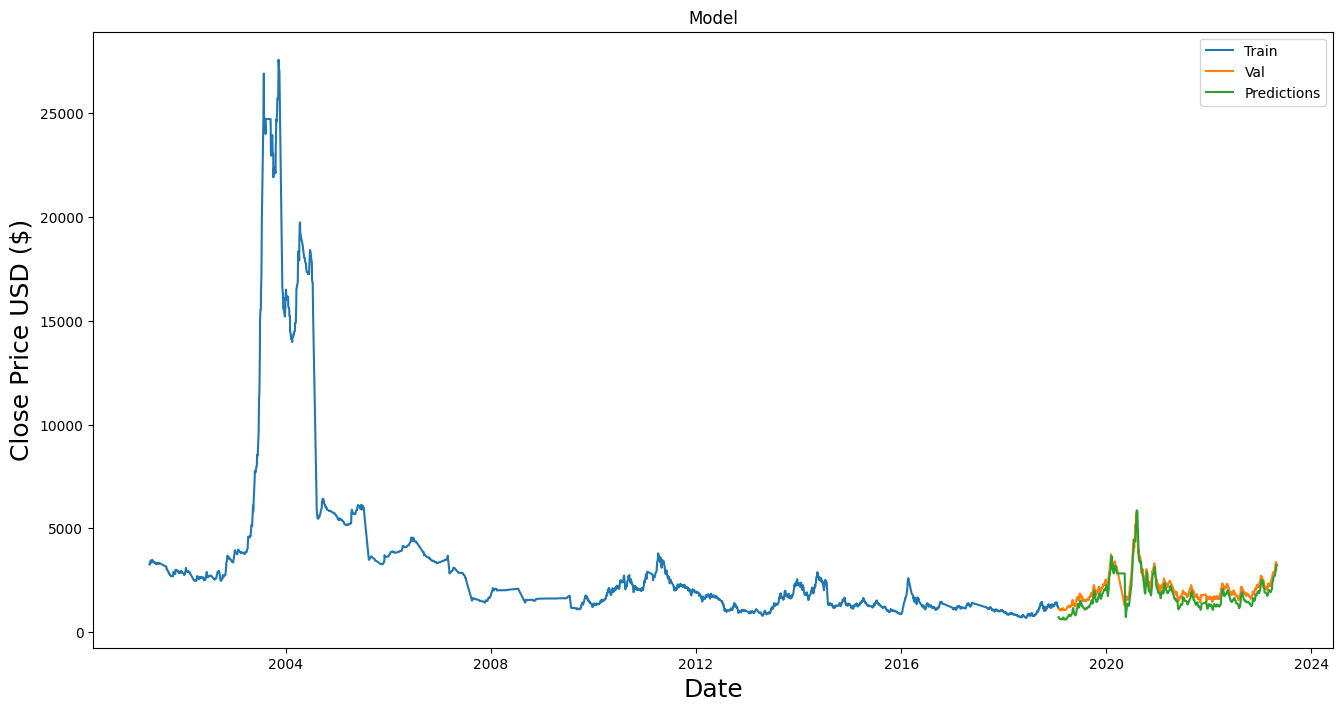

In [17]:
#Plot the data



train=data[:trainingDataLen]
valid=data[trainingDataLen:]
valid['Predictions']=predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)' , fontsize=18)
plt.plot(train['<CLOSE>'])
plt.plot(valid[['<CLOSE>', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [18]:
# aapl = pdr.get_data_yahoo('AAPL', start='2012-01-01', end='2019-12-17')
df = pd.read_csv('S_Saipa.csv',index_col='<DTYYYYMMDD>', parse_dates=True)
df = df.sort_index()
finalData = df.tail(1)
df = df.drop(finalData.index)
# Create a new data frame
new_df=df.filter(['<CLOSE>'])


# Get the last 60 day Closing price values and convert the dataframe to an array

# last_60_days=new_df[-60:].values

last_60_days = new_df.tail(60).values

# Scale the data to be values between 0 and 1

last_60_days_scaled=scalar.transform(last_60_days)
  
# Create an empty list

X_test=[]

X_test.append(last_60_days_scaled)

# Convert the numpy array

X_test=np.array(X_test)

# Reshape the data
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred_price=model.predict(X_test)

# Get the predicted scalar price
pred_price=scalar.inverse_transform(pred_price)

print(pred_price)



1/1 [==============================] - 0s 30ms/step
[[3238.657]]


In [19]:
print(finalData['<CLOSE>'])

<DTYYYYMMDD>
2023-04-29    3227.0
Name: <CLOSE>, dtype: float64


In [20]:
# Create a function for calculation Moving Average(MA)
def MA(data,period=30,column='<CLOSE>'):
  return data[column].rolling(window=period).mean()

In [21]:
# Create a function for calculation Exponential Moving Average(EMA)
def EMA(data,period=30,column='<CLOSE>'):
  return data[column].ewm(span=period).mean()

In [22]:
# Create two new columns for storing the 20 day and 50 day MA
df['MA20']=MA(df,20)
df['MA50']=MA(df,50)

In [23]:
# Create two new columns for storing the 20 day and 50 day MA
df['EMA20']=EMA(df,20)
df['EMA50']=EMA(df,50)

In [24]:
# Get the buy and sell signals

df['Signal']=np.where(df['MA20']>df['MA50'],1,0)
df['Position']=df['Signal'].diff()

df['Buy']=np.where(df['Position']==1, df['<CLOSE>'] , np.NAN)
df['Sell']=np.where(df['Position']==-1, df['<CLOSE>'], np.NAN)


In [25]:
# Get the buy and sell signals

df['Signal']=np.where(df['EMA20']>df['EMA50'],1,0)
df['Position']=df['Signal'].diff()

df['Buy']=np.where(df['Position']==1, df['<CLOSE>'] , np.NAN)
df['Sell']=np.where(df['Position']==-1, df['<CLOSE>'], np.NAN)


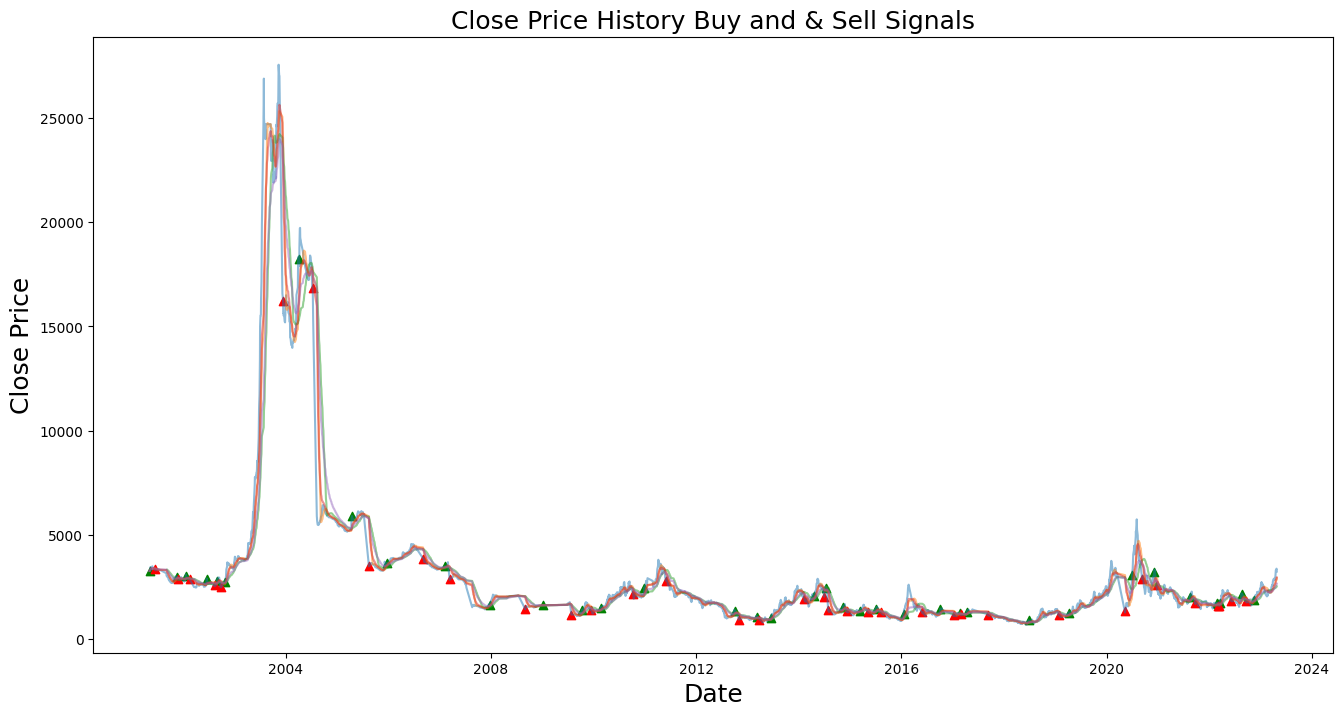

In [26]:
#Show the Close price with the MA ,WMA,EMA and Buy and Sell signals
plt.figure(figsize=(16,8))
plt.title('Close Price History Buy and & Sell Signals' , fontsize=18)
plt.plot(df['<CLOSE>'], alpha=0.5 , label='<CLOSE>')
plt.plot(df['MA20'], alpha=0.5 , label='MA20')
plt.plot(df['MA50'], alpha=0.5 , label='MA50')
plt.plot(df['EMA20'], alpha=0.5 , label='EMA20')
plt.plot(df['EMA50'], alpha=0.5 , label='EMA50')


plt.scatter(df.index,df['Buy'], alpha=1, label='Buy Signal', marker='^',color='green')

plt.scatter(df.index,df['Sell'], alpha=1, label='Sell Signal', marker='^',color='red')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()